All the imports go here:

In [1]:
## import required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import optim
import pandas as pd
import numpy as np


Import the data and put it into the dataloader  : SAI


In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Plot 1 image to check how it looks. 

In [14]:
data = iter(trainloader)
images,labels = data.next()

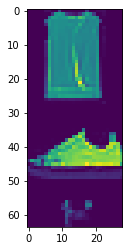

In [15]:
plt.imshow(images.resize_(images.size()[0],28));


## Build the pytorch class: SAI & OLUSEYI
- which activation layer to use?
- Relu? or 'swish' - Lets add both of these to the init class
- should we use dropout?
- or batch normilisation between layers?
- lets add some variables for the number of neurons in each layer rather then hard code in the classB

In [5]:
# Neurons in Layers varibales for number of nuerons in each layer. 
in_dim   = 784
hidden   = [300,200] # this is a good approach too
output   = 10

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.lay1 = nn.Linear(in_dim,  hidden[0])
        self.lay2 = nn.Linear(hidden[0], hidden[1])
        self.lay3 = nn.Linear(hidden[1],output)
        self.norm1 = nn.BatchNorm1d(hidden[0])
        self.norm2 = nn.BatchNorm1d(hidden[1]) # for layer 2 
        self.relu = nn.ReLU()
       #self.selu = nn.SELU()

        #self.swish = nn.

    def forward(self,X):
        X = self.lay1(X)
        X = self.norm1(X)
        X = F.relu(X)
        X = self.lay2(X)
        X = self.norm2(X) # layer 2 
        X = F.relu(X)
        X = self.lay3(X)
        X = F.log_softmax(X) #F.softmax(X,dim = 1) 
        return X

model = NeuralNetwork()
model



NeuralNetwork(
  (lay1): Linear(in_features=784, out_features=300, bias=True)
  (lay2): Linear(in_features=300, out_features=200, bias=True)
  (lay3): Linear(in_features=200, out_features=10, bias=True)
  (norm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

## build the training loop: TOBIAS & PARAM
- Whats our early stopping criteria?
- Which Optimizer to use 
- Learning rate to start with
- Where do we meaures our accuracy? Can we print the accuracy as we go?

In [7]:
optimizer = optim.Adam(model.parameters(),amsgrad=True, lr=0.001) # amsgrad=True we can try adding this to the adam
criterion = nn.NLLLoss()

In [8]:
epochs = 20
print_every = 60
min_val_loss = np.Inf
min_epochs = 5
n_epochs_stop = 6
epochs_no_improve = 0
early_stop = False
correct = 0
total = 0
d = {}

for e in range(epochs):
    val_loss = 0
    running_loss = 0
    epoch = e + 1
   
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):
        images.resize_(images.size()[0], 784)

        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        val_loss += loss.item()
        val_loss = val_loss / len(trainloader)
        running_loss += loss.item()

        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve +=1
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0

        if e > min_epochs and epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            early_stop = True
            break
        else:
            continue

    if early_stop:
        print("Stopped!")
        break

    model.eval()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):
            images.resize_(images.size()[0], 784)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print('Accuracy of the network on the test images: {0:.2f}'.format(
        100 * correct / total))
    accuracy = 100 * correct / total
    d[epoch] = accuracy
    


Epoch: 1/20
	Iteration: 0	 Loss: 0.0400
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
	Iteration: 60	 Loss: 0.7608
	Iteration: 120	 Loss: 0.4997
	Iteration: 180	 Loss: 0.4871
	Iteration: 240	 Loss: 0.4482
	Iteration: 300	 Loss: 0.4824
	Iteration: 360	 Loss: 0.4739
	Iteration: 420	 Loss: 0.4295
	Iteration: 480	 Loss: 0.3973
	Iteration: 540	 Loss: 0.3864
	Iteration: 600	 Loss: 0.3926
	Iteration: 660	 Loss: 0.3994
	Iteration: 720	 Loss: 0.3980
	

## plot results:
- Plot of the accuracy imporving vs epochs

Text(0.5, 1.0, 'Accuracy vs Epochs')

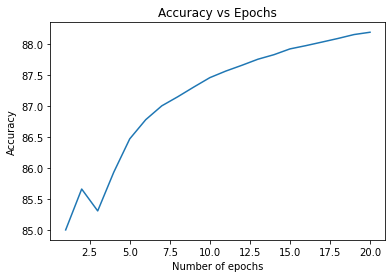

In [13]:
plt.plot(d.keys(),d.values())
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

## identify the incorrect items 

In [10]:
# gives index of predicted class   
# add all the array                                              
def get_misclassified(outputs):
    top_p, top_class = outputs.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    # This is a list of the indexs in the batch 
    misclassified = [index for index,value in enumerate(equals) if value.item() is False] 
    print(list(misclassified))

## Optional Optuna HyperTunning 

In [11]:

 import optuna
 def objective(trial): #here it's trials next line down it is trial
     optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])
     lr = trial.suggest_float('lr',1e-5, 1e-1, log=True)
     optimizer = getattr(optim,optimizer_name)(model, lr=lr)


In [12]:
 study = optuna.create_study(direction='maximize')
 study.optimize(objective,n_trials=100,timeout=600)

#pruned_trials = [t for t in study.trials if t.state==optuna.trial.TrialState.PRUNED]
#complete_trials = [t for t in study.trials if t.state==optuna.trial.TrialState.COMPLETE]
#n_trials = study.best_trial                                          
# trials in cell defined above you have trials and trial

[I 2021-02-26 16:08:27,982] A new study created in memory with name: no-name-d3e11c53-21e8-4003-b54e-8110ece7a84a
[W 2021-02-26 16:08:27,984] Trial 0 failed because of the following error: TypeError("'NeuralNetwork' object is not iterable")
Traceback (most recent call last):
  File "/root/venv/lib/python3.7/site-packages/optuna/_optimize.py", line 211, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-11-63791cc43571>", line 5, in objective
    optimizer = getattr(optim,optimizer_name)(model, lr=lr)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/optim/adam.py", line 48, in __init__
    super(Adam, self).__init__(params, defaults)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/optim/optimizer.py", line 45, in __init__
    param_groups = list(params)
TypeError: 'NeuralNetwork' object is not iterable


TypeError: 'NeuralNetwork' object is not iterable

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=421052d2-c9d8-4fc5-bfa9-327ae9972670' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>